In [59]:
library(regclass)
library(ppcor)
library(tseries)
library(stringr)
library(lmtest)

In [287]:
# return the R squared value of guo ~ guo_history + yin_history
self_autoregression <- function(x,y,lags){
    n <- length(x)
    x_hist <- x[1:(n-lags)]
    y_hist <- y[1:(n-lags)]
    Y <- y[(lags+1):n]
    m <- lm(Y~x_hist+y_hist+0)
    return (summary(m)$r.squared)
}

# select best time lags
select_time_lags <- function(z,thres = 0.1){
    pacf = pacf(z,20)
    for (i in c(1:20)){
        if (abs(pacf$acf[i])<thres){
            return (i)
        }
    }
    return (-1)
}

# a helper function to remove an element with certain value from a list
remove <- function(arr,value){
    for(i in c(1:length(arr))){
        if(arr[i]==value){
            r_arr <- arr[-i]
            return (r_arr)
        }
    }
    print("remove failure")
    cat(arr," ",value,"\n")
    return (arr)
}

filter_cause <- function(X,y, thres = 0.1){
    n <- dim(X)[2]
    lags <- c()
    R_squared = c()
    for (i in c(1:n)){
        lag = select_time_lags(X[,i])
        r_sq <- self_autoregression(X[,i],y,lag)
        R_squared = append(R_squared,c(r_sq))
    }

    cause_indices <- c()
    remain <- c(1:n)
    while(length(remain)>0){
        
        j <- which.max(R_squared)
        cause_indices <- append(cause_indices,c(j))
        remain <- remove(remain,j)
        R_squared[j] <- 0
        
        # pruning
        to_remove <- c()
        for(i in remain){
            df <- data.frame(x=X[,j],y=y,z=X[,i])
            pcor <- pcor(df)$estimate[2,3]
            
            if(abs(pcor)<=thres){
                #cat(i," ",pcor,"\n")
                to_remove <- append(to_remove,c(i))
                R_squared[i] <- 0
            }
        }
        for(rm in to_remove){
            remain <- remove(remain,rm)
        }
    }
    return (cause_indices)
}

equal_list <- function(a,b){
    a <- a[order(a)]
    b <- b[order(b)]
    return (identical(a,b))
}

process_df <- function(data){
    A <- data$X..A...
    B <- data$X..B...
    C <- data$X..C...
    D <- data$X..D...
    E <- data$X..E...
    F <- data$X..F...
    AB <- data$X..A....B..
    ABC <- data$X..A....B....C..
    DE <- data$X..D....E..
    DEF <- data$X..D....E....F..
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
    D <- diff(D)
    E <- diff(E)
    F <- diff(F)
    AB <- diff(AB)
    ABC <- diff(ABC)
    DE <- diff(DE)
    DEF <- diff(DEF)
    df <- data.frame(A,B,C,D,E,F,AB,ABC,DE,DEF)
    return(df)
}

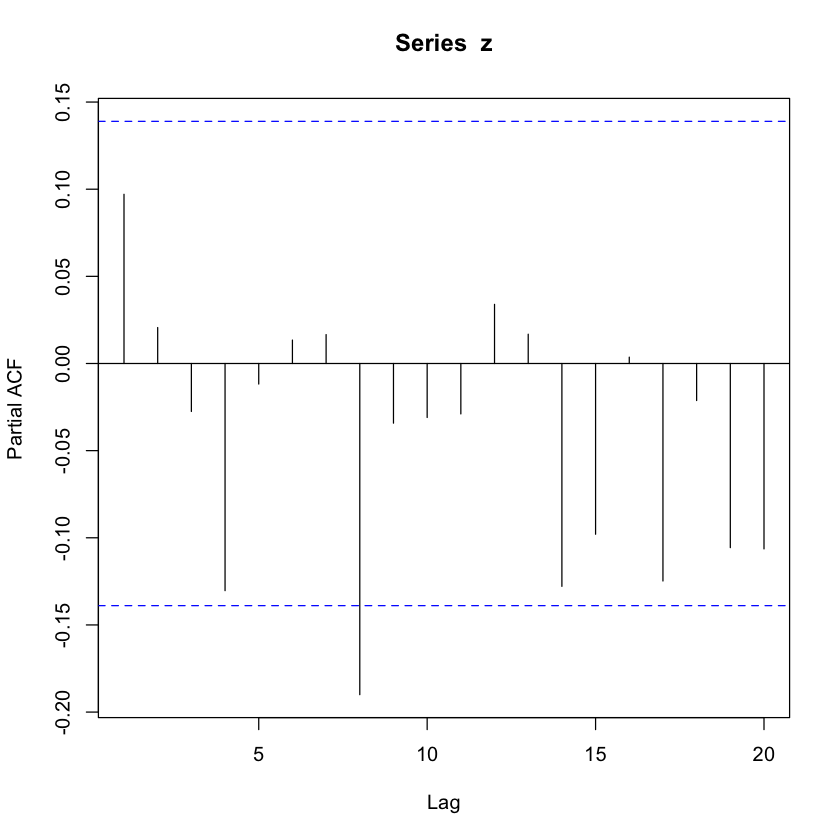

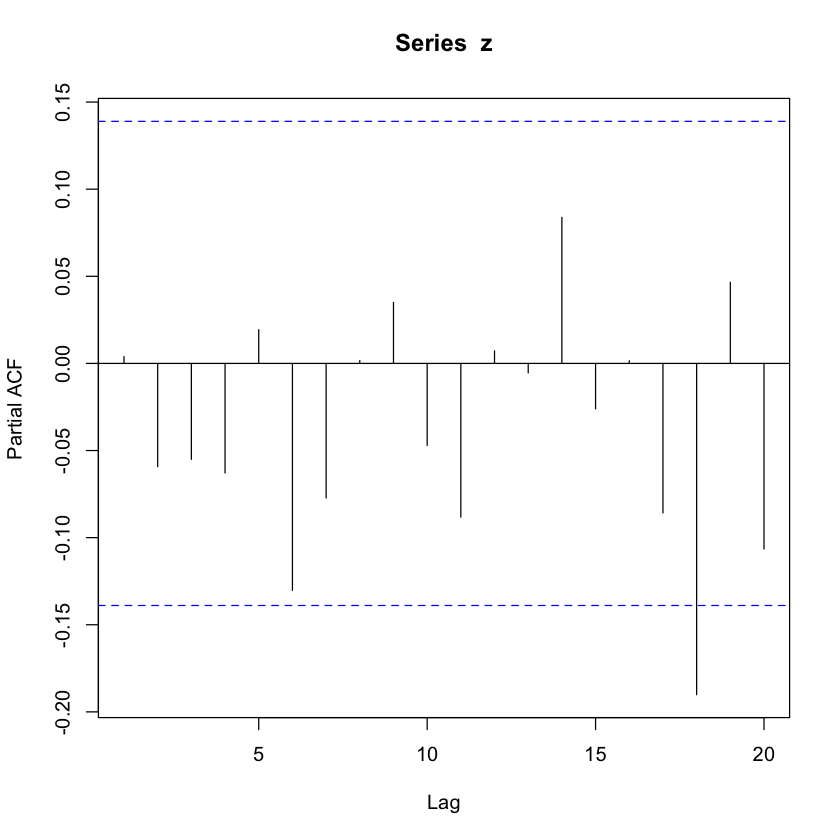

ERROR: Error in causes.append(index): could not find function "causes.append"


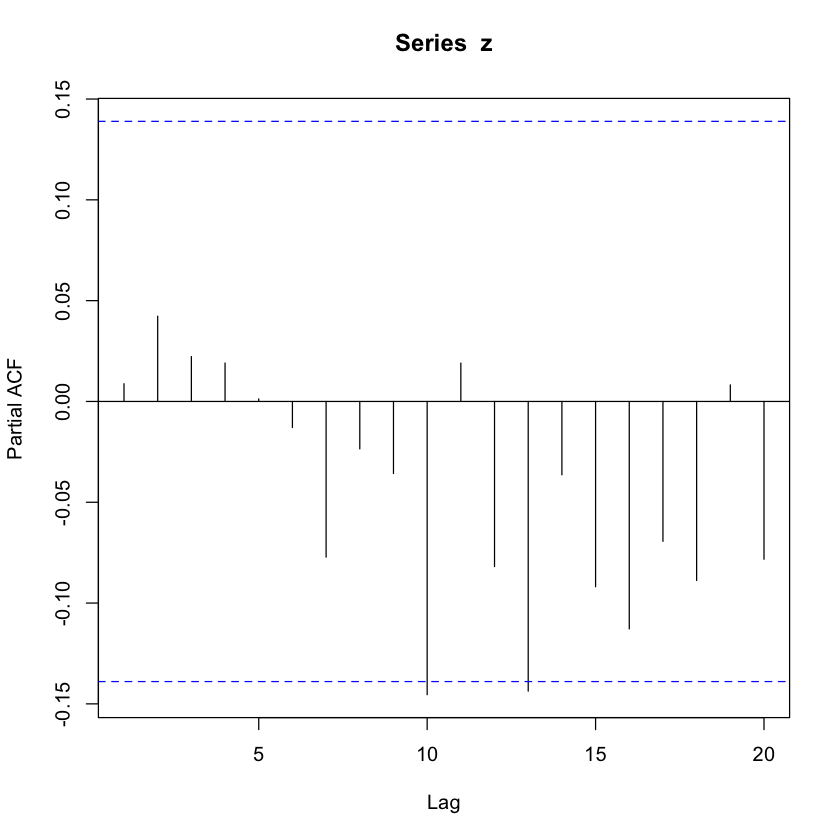

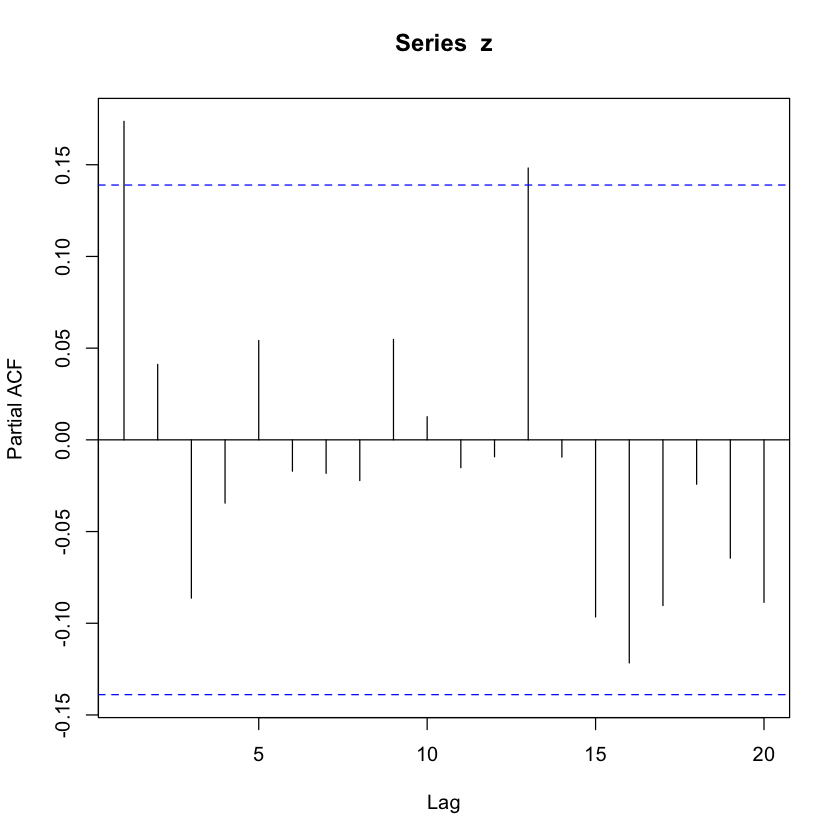

In [332]:
correct <- 0
AB_causes = c(2)
ABC_causes = c(7)
DE_causes = c(5)
DEF_causes = c(9)
for (i in 1:100){
    num <- str_pad(i,3,pad="0")
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    df <- process_df(data)
    
    #testing causes of AB
    causes = c()
    for (index in 1:10){
        if (index==7) {continue}
        X <- df[,index]
        Y <- df$AB
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes.append(index)}
    }
    if (equal_list(AB_causes,causes)) {correct <- correct+1}
    
    # testing causes of ABC
    causes = c()
    for (index in 1:10){
        if (index==8) {continue}
        X <- df[,index]
        Y <- df$ABC
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes.append(index)}
    }
    if (equal_list(ABC_causes,causes)) {correct <- correct+1}
    
    # testing causes of DE
    causes = c()
    for (index in 1:10){
        if (index==9) {continue}
        X <- df[,index]
        Y <- df$DE
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes.append(index)}
    }
    if (equal_list(DE_causes,causes)) {correct <- correct+1}
    
    # testing causes of DEF
    causes = c()
    for (index in 1:10){
        if (index==10) {continue}
        X <- df[,index]
        Y <- df$DEF
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes.append(index)}
    }
    if (equal_list(DEF_causes,causes)) {correct <- correct+1}
}
    
    

In [333]:
correct

[1] 0

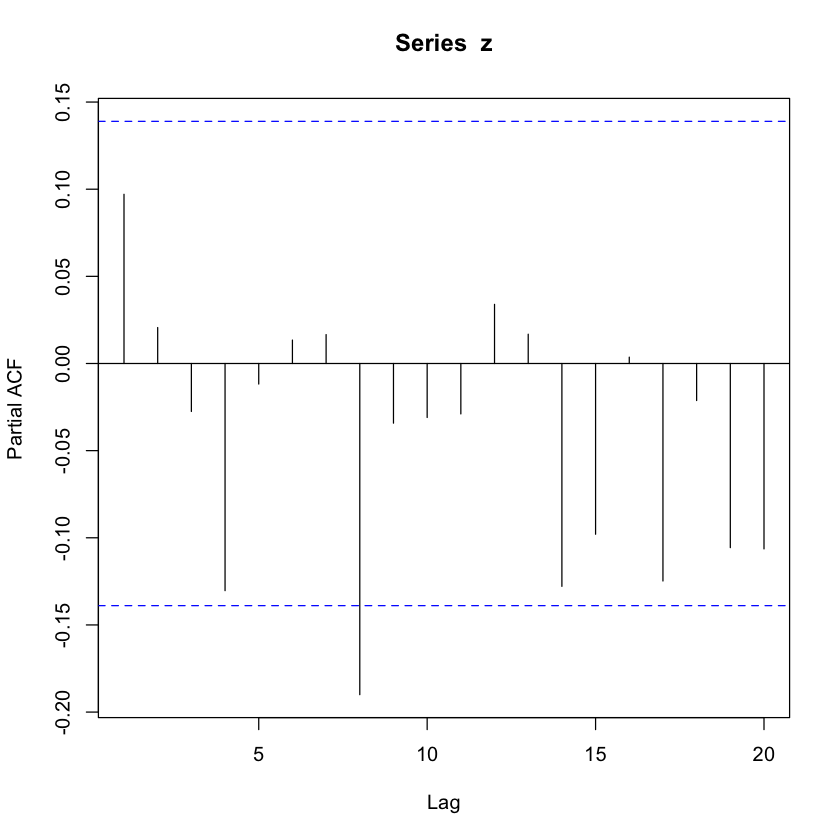

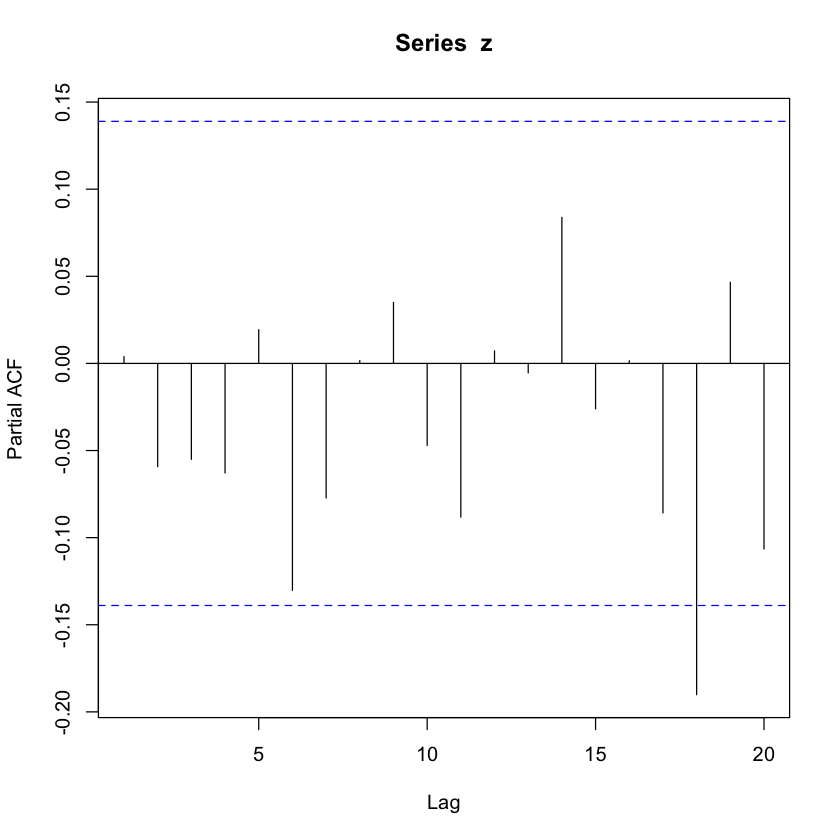

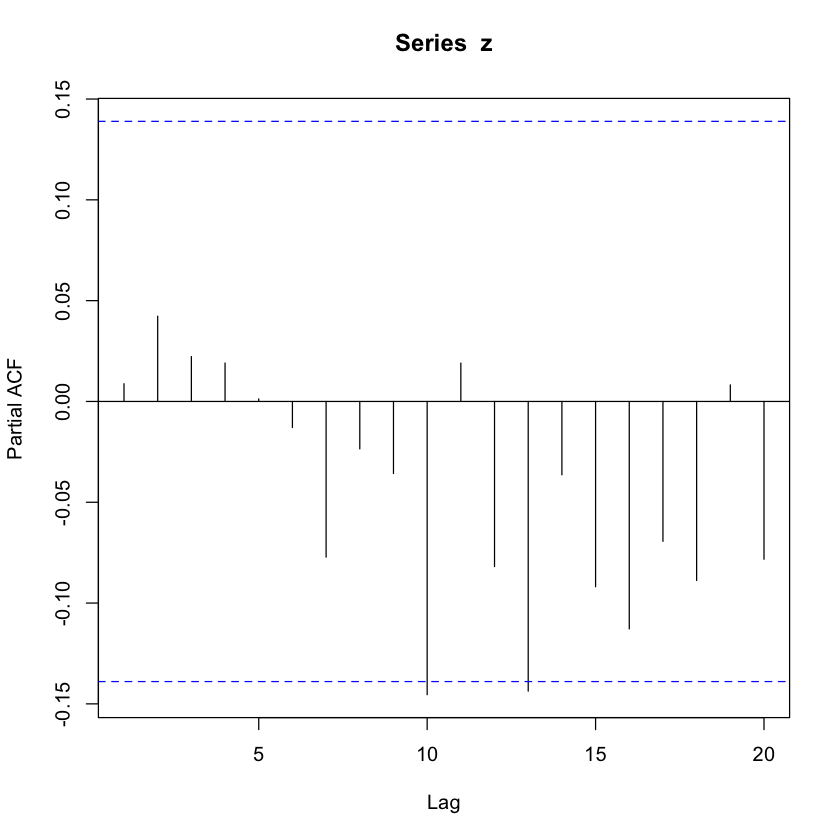

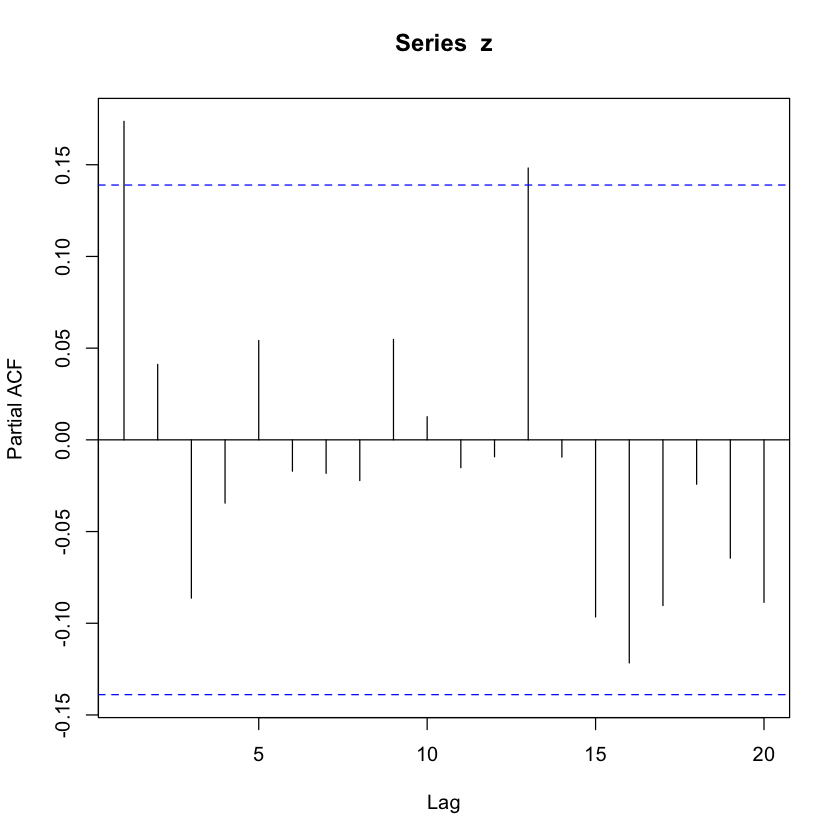

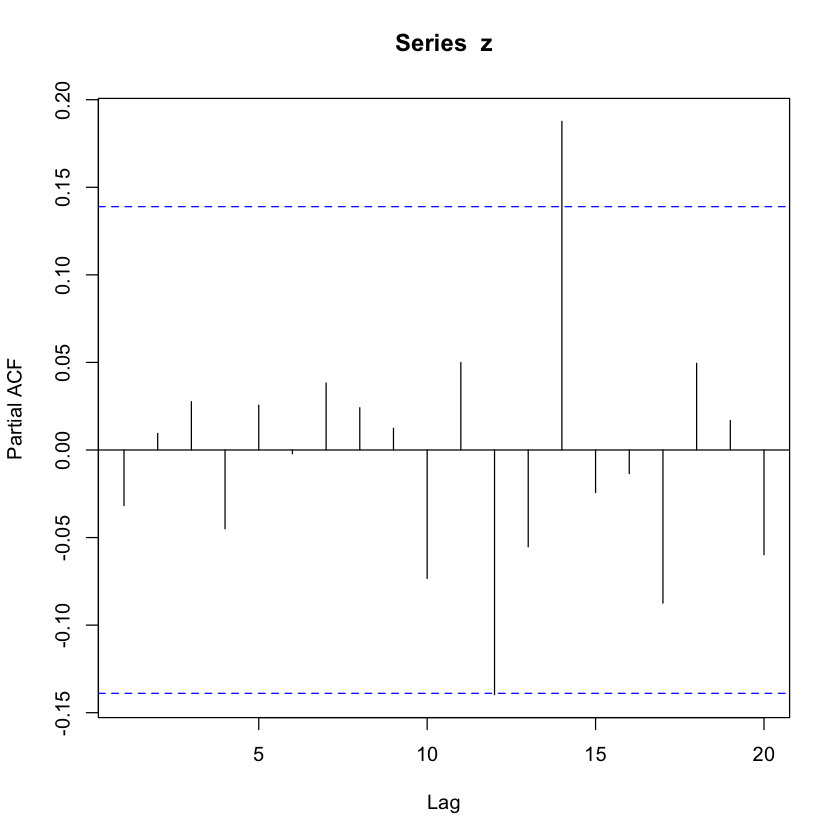

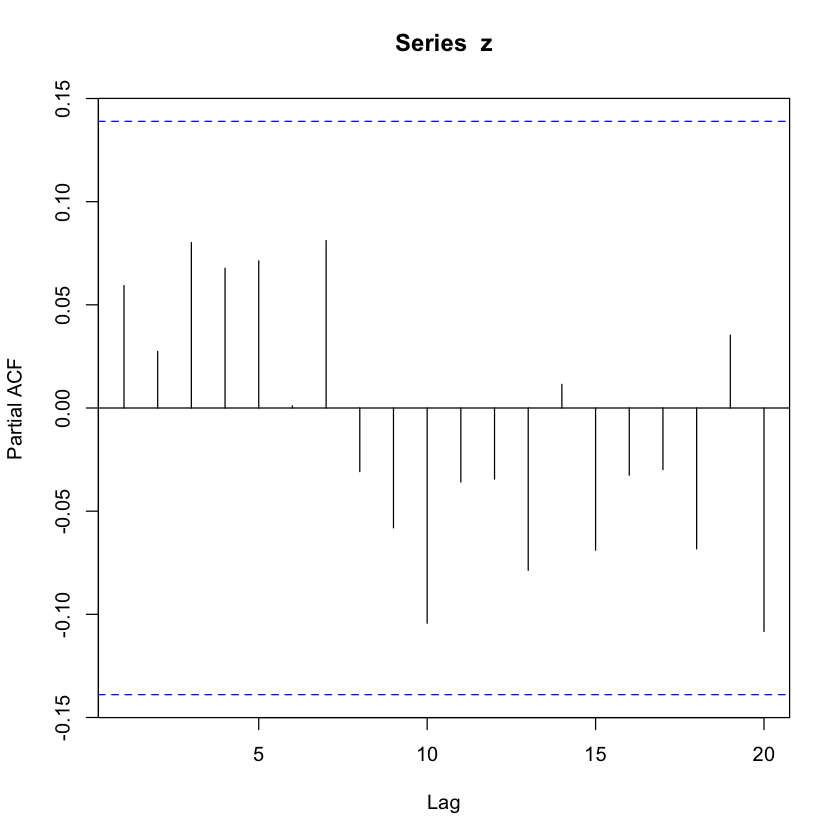

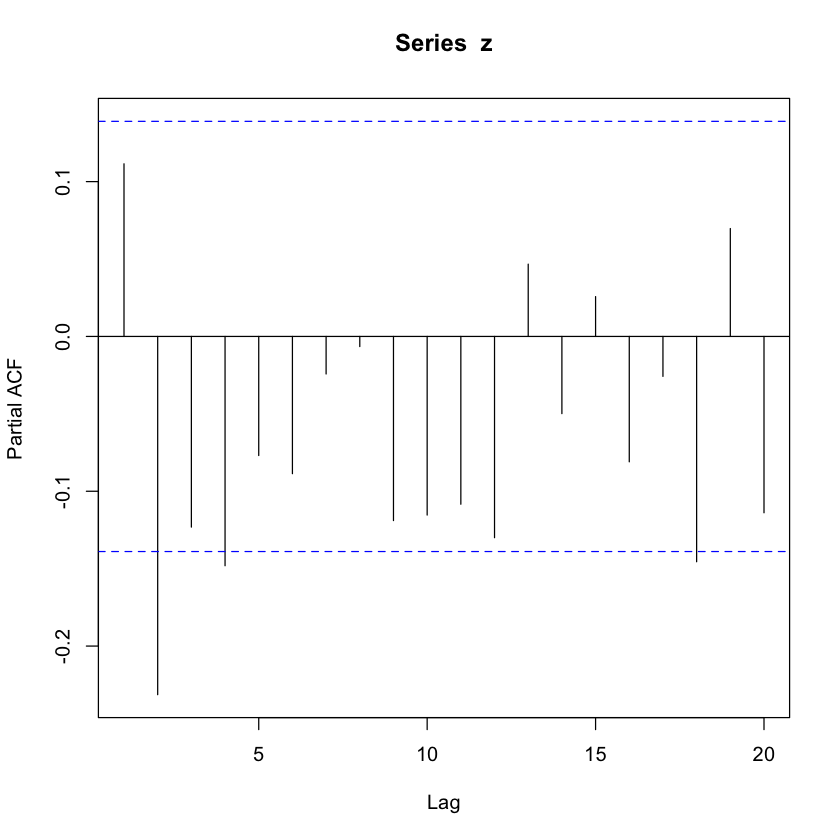

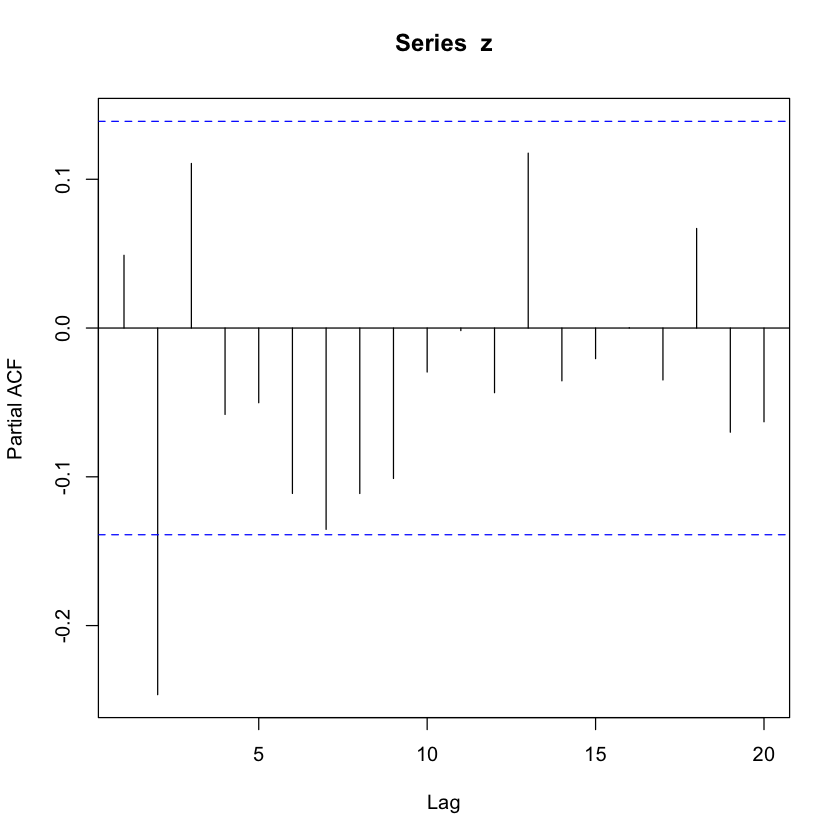

ERROR: Error in order(b): argument 1 is not a vector


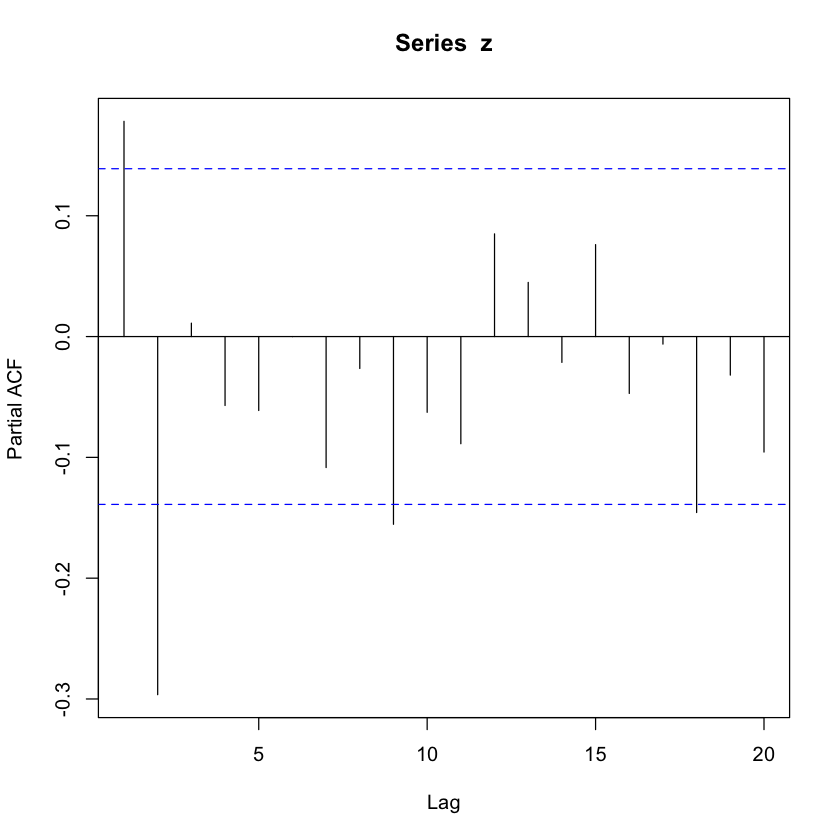

In [342]:
# num <- str_pad(i,3,pad="0")
correct <- 0
AB_causes = c(2)
ABC_causes = c(7)
DE_causes = c(5)
DEF_causes = c(9)
num="001"
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    df <- process_df(data)
    
    #testing causes of AB
    causes = c()
    for (index in 1:10){
        if (index==7) {next}
        X <- df[,index]
        Y <- df$AB
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){append(causes,index)}
    }
    if (equal_list(AB_causes,causes)) {correct <- correct+1}
    
    # testing causes of ABC
    causes = c()
    for (index in 1:10){
        if (index==8) {next}
        X <- df[,index]
        Y <- df$ABC
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){append(causes,index)}
    }
    if (equal_list(ABC_causes,causes)) {correct <- correct+1}
    
    # testing causes of DE
    causes = c()
    for (index in 1:10){
        if (index==9) {next}
        X <- df[,index]
        Y <- df$DE
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){append(causes,index)}
    }
    if (equal_list(DE_causes,causes)) {correct <- correct+1}
    
    # testing causes of DEF
    causes = c()
    for (index in 1:10){
        if (index==10) {next}
        X <- df[,index]
        Y <- df$DEF
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){append(causes,index)}
    }
    if (equal_list(DEF_causes,causes)) {correct <- correct+1}

In [337]:
equal_list

NULL

In [14]:
a <- c(1,2,3)
b <- c(2,10,1)
equal_list(a,b)

[1] FALSE

In [28]:

haha = c(1,2,3,4,5)
gg = c(2,3,4,5,6)
df <- data.frame(haha,gg)

In [29]:
haha <- diff(haha)
dff <- data.frame(haha)

In [31]:
dff$gg <- diff(gg)

In [32]:
dff

haha,gg
<dbl>,<dbl>
1,1
1,1
1,1
1,1


In [224]:
data <- read.csv("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data001.csv")
#data <- read.csv("/Users/suhong/Downloads/simu_datawq.csv")

In [60]:
process_df <- function(data){
    A <- data$X..A...
    B <- data$X..B...
    C <- data$X..C...
    D <- data$X..D...
    E <- data$X..E...
    F <- data$X..F...
    AB <- data$X..A....B..
    ABC <- data$X..A....B....C..
    DE <- data$X..D....E..
    DEF <- data$X..D....E....F..
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
    D <- diff(D)
    E <- diff(E)
    F <- diff(F)
    AB <- diff(AB)
    ABC <- diff(ABC)
    DE <- diff(DE)
    DEF <- diff(DEF)
    df <- data.frame(A,B,C,D,E,F,AB,ABC,DE,DEF)
    return(df)
}

In [225]:
df <- process_df(data)

In [290]:
df[100:120,]

,A,B,C,D,E,F,AB,ABC,DE,DEF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100,2,1,1,1,1,0,4,6,-1,0
101,0,-2,-1,1,1,-3,-1,1,2,-6
102,3,0,-1,2,0,0,-2,-1,2,0
103,-1,-3,-1,-3,2,-3,-9,-3,1,0
104,-1,1,-1,4,1,0,5,4,7,3
105,1,3,0,3,3,2,11,6,-3,5
106,-1,0,0,2,1,4,-2,10,4,-2
107,-2,-2,1,0,0,0,1,-1,3,5
108,2,2,0,3,-2,3,0,0,5,14


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,186,NA,NA,NA
2,190,-4,2.667234,0.03378154


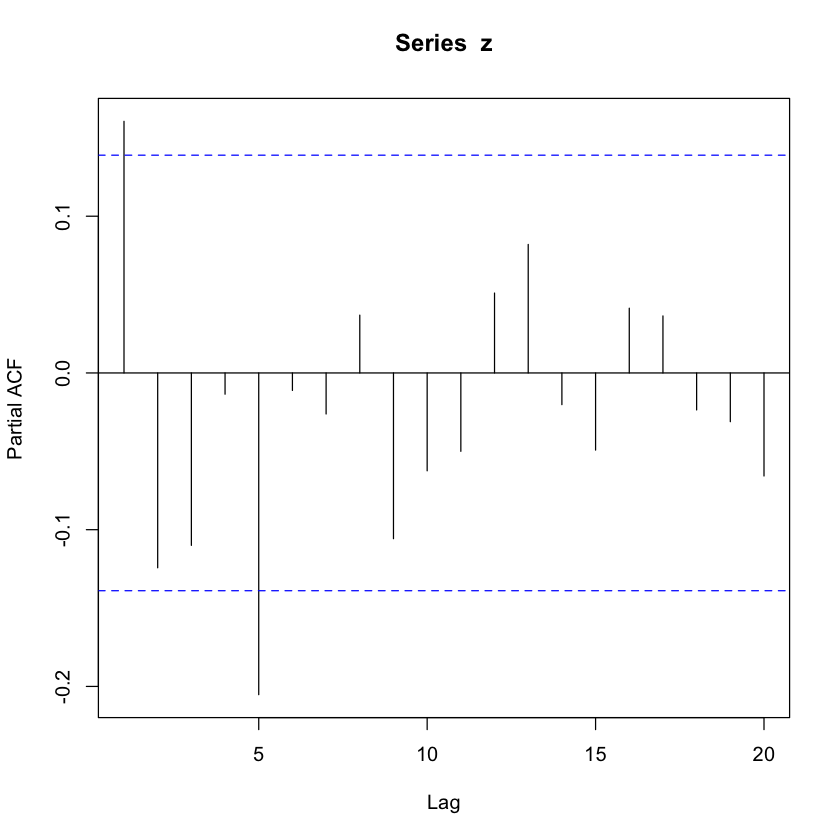

In [286]:
# grangertest(X,y,order = lag)
X <- df$DE
Y <- df$DEF
lag <- select_time_lags(X,thres=0.05)
grangertest(X,Y,order=lag)

[1] 3

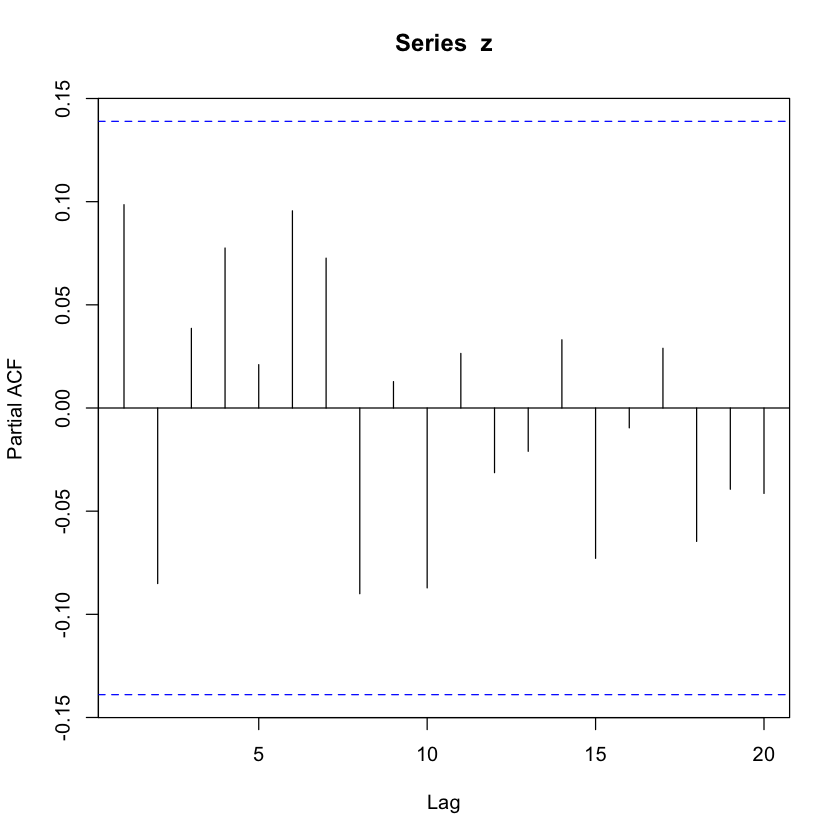

In [275]:
select_time_lags(X,thres=0.05)


Partial autocorrelations of series ‘X’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.099 -0.085  0.039  0.078  0.021  0.096  0.073 -0.090  0.013 -0.087  0.026 
    12     13     14     15     16     17     18     19     20     21     22 
-0.031 -0.021  0.033 -0.073 -0.010  0.029 -0.065 -0.039 -0.041 -0.026 -0.056 

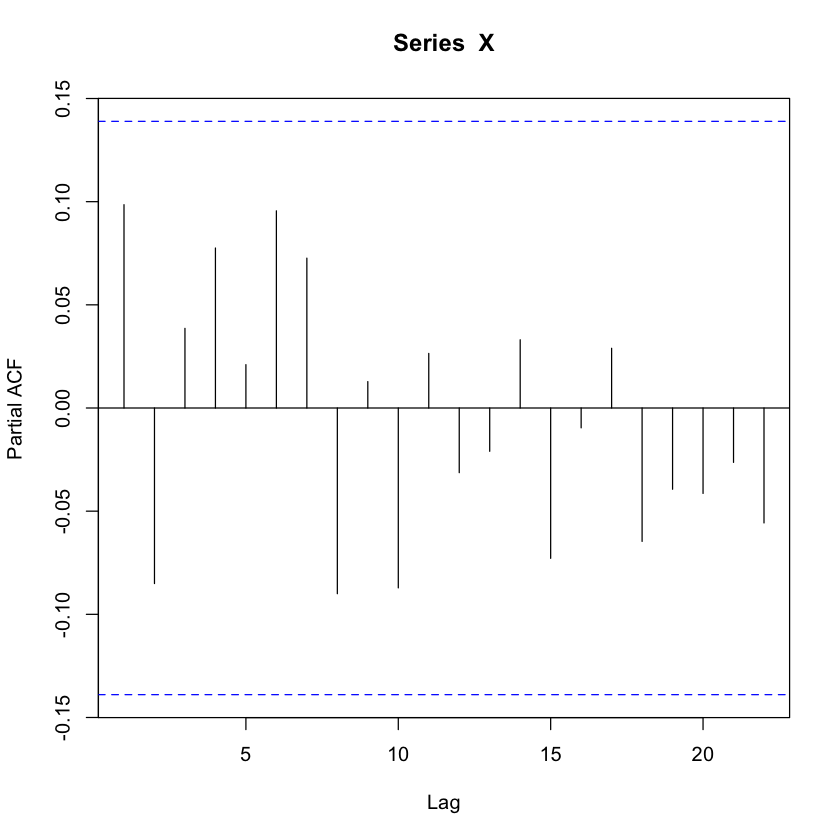

In [276]:
pacf <- pacf(X)
pacf

In [291]:
names(grangertest(X,Y,order=lag))

[1] "Res.Df" "Df"     "F"      "Pr(>F)"

In [323]:
a <- grangertest(X,Y,order=lag)$'Pr(>F)'
a <- as.numeric(a)
if(any(a>1))
{print("haha")
}else{
    print("fuck")}

ERROR: Error in if (any(a > 1)) {: missing value where TRUE/FALSE needed


In [329]:
grangertest(X,Y,order=lag)[2,4]

[1] 0.03378154

In [310]:
type(a)

ERROR: Error in type(a): could not find function "type"
